# Explore here

In [2]:
import pandas as pd

In [3]:
# Apertura de datasets

appearence = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/appearances.csv")
club_games = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/club_games.csv")
clubs = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/clubs.csv")
competitions = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/competitions.csv")
game_events = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/game_events.csv")
game_lineups = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/game_lineups.csv")
transfers = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/transfers.csv")
players = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/players.csv")
games = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/games.csv")
player_valuations = pd.read_csv("/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/player_valuations.csv")

#  Datasets en un diccionario para organizarlos
datasets = {"Appearence": appearence, "Club Games": club_games, "Clubs": clubs, "Competitions": competitions,
            "Game events":game_events, "Game Lineups":game_lineups, "Transfers":transfers, "Players":players,
            "Games":games, "Player Valuations":player_valuations}


for name, dataset in datasets.items():
    print(f"El shape de {name}: {dataset.shape}")


El shape de Appearence: (697243, 13)
El shape de Club Games: (145274, 11)
El shape de Clubs: (439, 17)
El shape de Competitions: (44, 11)
El shape de Game events: (555044, 10)
El shape de Game Lineups: (474540, 10)
El shape de Transfers: (78658, 10)
El shape de Players: (32480, 23)
El shape de Games: (72637, 23)
El shape de Player Valuations: (494561, 5)


In [4]:
for name, dataset in datasets.items():
    print(f"Las columnas de {name}: {dataset.columns}")

Las columnas de Appearence: Index(['appearance_id', 'game_id', 'player_id', 'player_club_id',
       'player_current_club_id', 'date', 'player_name', 'competition_id',
       'yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played'],
      dtype='object')
Las columnas de Club Games: Index(['game_id', 'club_id', 'own_goals', 'own_position', 'own_manager_name',
       'opponent_id', 'opponent_goals', 'opponent_position',
       'opponent_manager_name', 'hosting', 'is_win'],
      dtype='object')
Las columnas de Clubs: Index(['club_id', 'club_code', 'name', 'domestic_competition_id',
       'total_market_value', 'squad_size', 'average_age', 'foreigners_number',
       'foreigners_percentage', 'national_team_players', 'stadium_name',
       'stadium_seats', 'net_transfer_record', 'coach_name', 'last_season',
       'filename', 'url'],
      dtype='object')
Las columnas de Competitions: Index(['competition_id', 'competition_code', 'name', 'sub_type', 'type',
       'country_id', 'c

In [5]:
for name, df in datasets.items():
    duplicados = df.duplicated()
    num_duplicados = duplicados.sum()
    print(f"La cantidad de duplicados en {name}: {num_duplicados}")


La cantidad de duplicados en Appearence: 0
La cantidad de duplicados en Club Games: 0
La cantidad de duplicados en Clubs: 0
La cantidad de duplicados en Competitions: 0
La cantidad de duplicados en Game events: 0
La cantidad de duplicados en Game Lineups: 0
La cantidad de duplicados en Transfers: 0
La cantidad de duplicados en Players: 0
La cantidad de duplicados en Games: 0
La cantidad de duplicados en Player Valuations: 0


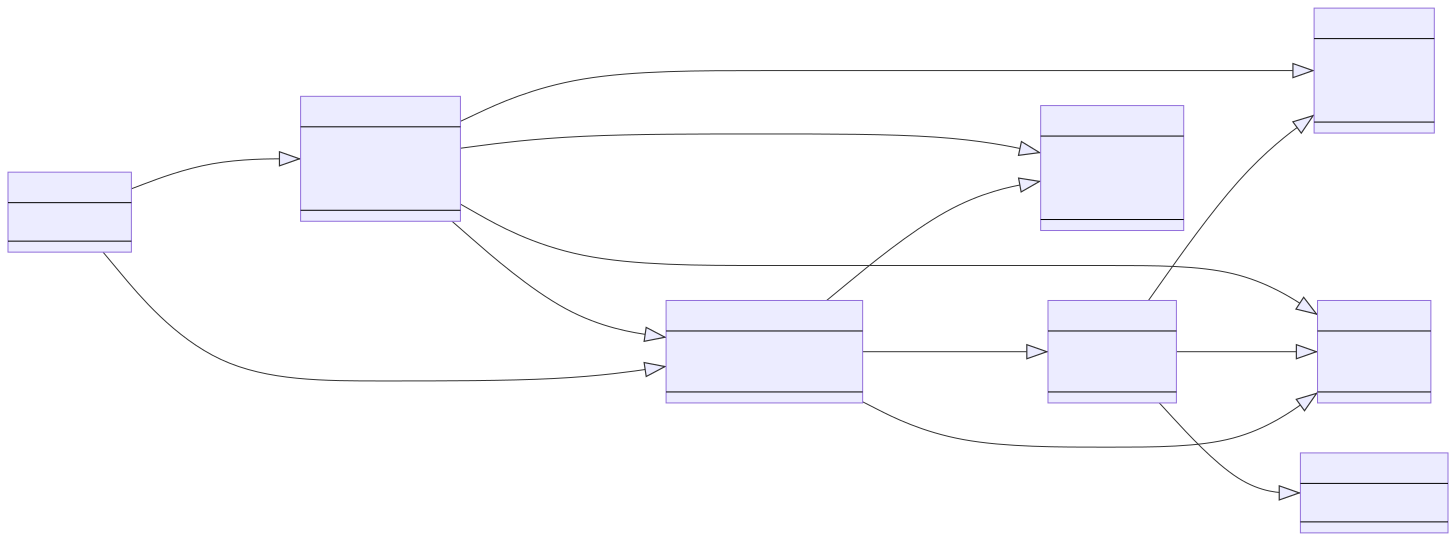

In [5]:
from IPython.display import SVG, display

display(SVG(filename="/workspaces/proyecto_final_transfer/data/datos_de_transfer/proyecto final/diagram.svg"))

In [6]:
appearence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697243 entries, 0 to 697242
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   appearance_id           697243 non-null  object 
 1   game_id                 697243 non-null  int64  
 2   player_id               697243 non-null  int64  
 3   player_club_id          697243 non-null  int64  
 4   player_current_club_id  697243 non-null  int64  
 5   date                    697243 non-null  object 
 6   player_name             697243 non-null  object 
 7   competition_id          697243 non-null  object 
 8   yellow_cards            697243 non-null  int64  
 9   red_cards               697243 non-null  int64  
 10  goals                   697243 non-null  int64  
 11  assists                 697242 non-null  float64
 12  minutes_played          697242 non-null  float64
dtypes: float64(2), int64(7), object(4)
memory usage: 69.2+ MB


In [14]:
messi=appearence[appearence['player_id'] == 28003]
messi

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
8135,2244378_28003,2244378,28003,131,583,2012-08-19,Lionel Messi,ES1,0,0,2,0.0,90.0
8929,2244388_28003,2244388,28003,131,583,2012-08-22,Lionel Messi,SUC,0,0,1,0.0,90.0
11912,2242828_28003,2242828,28003,131,583,2012-08-26,Lionel Messi,ES1,0,0,2,0.0,90.0
12883,2244389_28003,2244389,28003,131,583,2012-08-29,Lionel Messi,SUC,0,0,1,0.0,90.0
15970,2242881_28003,2242881,28003,131,583,2012-09-02,Lionel Messi,ES1,0,0,0,1.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
685288,2899620_28003,2899620,28003,131,583,2017-10-01,Lionel Messi,ES1,0,0,2,1.0,90.0
686845,2899617_28003,2899617,28003,131,583,2017-10-14,Lionel Messi,ES1,0,0,0,0.0,90.0
689143,2917396_28003,2917396,28003,131,583,2017-10-18,Lionel Messi,CL,0,0,1,1.0,90.0
690644,2899630_28003,2899630,28003,131,583,2017-10-21,Lionel Messi,ES1,0,0,0,1.0,90.0


In [30]:
messi.game_id.value_counts()

game_id
2899649    1
2244378    1
2244388    1
2242828    1
2244389    1
          ..
2242908    1
2243009    1
2262211    1
2242996    1
2243006    1
Name: count, Length: 269, dtype: int64

In [ ]:
print(appearence["player_id"].value_counts())
print()
print(players["player_id"].value_counts())
print()
print(player_valuations["player_id"].value_counts())

player_id
28003     269
32467     269
61253     264
8198      260
39153     260
         ... 
446302      1
336168      1
458466      1
465967      1
409100      1
Name: count, Length: 14819, dtype: int64

player_id
1260412    1
1260415    1
1260733    1
1262359    1
1262360    1
          ..
77         1
80         1
109        1
123        1
132        1
Name: count, Length: 32480, dtype: int64

player_id
39333     53
44162     53
39153     52
57162     51
35664     50
          ..
149618     1
142326     1
874874     1
874877     1
875114     1
Name: count, Length: 30956, dtype: int64


In [31]:
messi_player=players[players['player_id'] == 28003]
messi_player

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
2347,28003,Lionel,Messi,Lionel Messi,2022,583,lionel-messi,Argentina,Rosario,Argentina,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0


In [32]:
messi_pl_val=player_valuations[player_valuations['player_id'] == 28003]
messi_pl_val

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
2248,28003,2004-12-20,3000000,583,FR1
4728,28003,2005-12-28,5000000,583,FR1
4959,28003,2006-01-20,15000000,583,FR1
9674,28003,2007-07-26,40000000,583,FR1
11042,28003,2007-09-12,60000000,583,FR1
14290,28003,2008-02-04,55000000,583,FR1
17826,28003,2008-07-10,55000000,583,FR1
23698,28003,2009-01-26,55000000,583,FR1
25586,28003,2009-04-28,60000000,583,FR1
28672,28003,2009-07-22,70000000,583,FR1


In [33]:
messi_pl_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43 entries, 2248 to 458676
Data columns (total 5 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   player_id                            43 non-null     int64 
 1   date                                 43 non-null     object
 2   market_value_in_eur                  43 non-null     int64 
 3   current_club_id                      43 non-null     int64 
 4   player_club_domestic_competition_id  43 non-null     object
dtypes: int64(3), object(2)
memory usage: 2.0+ KB


In [9]:
result = pd.merge(appearence,players , on='player_id', how='inner')  # 'on' especifica la columna común
print(result.shape)
print(result["player_id"].value_counts())
duplicados = result.duplicated()
num_duplicados = duplicados.sum()
print(f"La cantidad de duplicados: {num_duplicados}")

(697243, 35)
player_id
28003     269
32467     269
61253     264
8198      260
39153     260
         ... 
446302      1
336168      1
458466      1
465967      1
409100      1
Name: count, Length: 14819, dtype: int64
La cantidad de duplicados: 0


In [11]:
messi2=result[result['player_id'] == 28003]
messi2

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
8135,2244378_28003,2244378,28003,131,583,2012-08-19,Lionel Messi,ES1,0,0,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0
8929,2244388_28003,2244388,28003,131,583,2012-08-22,Lionel Messi,SUC,0,0,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0
11912,2242828_28003,2242828,28003,131,583,2012-08-26,Lionel Messi,ES1,0,0,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0
12883,2244389_28003,2244389,28003,131,583,2012-08-29,Lionel Messi,SUC,0,0,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0
15970,2242881_28003,2242881,28003,131,583,2012-09-02,Lionel Messi,ES1,0,0,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685288,2899620_28003,2899620,28003,131,583,2017-10-01,Lionel Messi,ES1,0,0,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0
686845,2899617_28003,2899617,28003,131,583,2017-10-14,Lionel Messi,ES1,0,0,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0
689143,2917396_28003,2917396,28003,131,583,2017-10-18,Lionel Messi,CL,0,0,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0
690644,2899630_28003,2899630,28003,131,583,2017-10-21,Lionel Messi,ES1,0,0,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0


In [16]:
messi.describe()

,game_id,player_id,player_club_id,player_current_club_id,yellow_cards,red_cards,goals,assists,minutes_played
count,2.690000e+02,269.0,269.0,269.0,269.000000,269.0,269.000000,269.000000,269.000000
mean,2.518100e+06,28003.0,131.0,583.0,0.100372,0.0,1.003717,0.412639,85.148699
std,1.943895e+05,0.0,0.0,0.0,0.301055,0.0,0.956120,0.655622,16.044255
min,2.242828e+06,28003.0,131.0,583.0,0.000000,0.0,0.000000,0.000000,10.000000
25%,2.341255e+06,28003.0,131.0,583.0,0.000000,0.0,0.000000,0.000000,90.000000
50%,2.490852e+06,28003.0,131.0,583.0,0.000000,0.0,1.000000,0.000000,90.000000
75%,2.675299e+06,28003.0,131.0,583.0,0.000000,0.0,2.000000,1.000000,90.000000
max,2.917396e+06,28003.0,131.0,583.0,1.000000,0.0,4.000000,3.000000,120.000000


In [17]:
messi2.describe()

,game_id,player_id,player_club_id,player_current_club_id,yellow_cards,red_cards,goals,assists,minutes_played,last_season,current_club_id,height_in_cm,market_value_in_eur,highest_market_value_in_eur
count,2.690000e+02,269.0,269.0,269.0,269.000000,269.0,269.000000,269.000000,269.000000,269.0,269.0,269.0,269.0,269.0
mean,2.518100e+06,28003.0,131.0,583.0,0.100372,0.0,1.003717,0.412639,85.148699,2022.0,583.0,170.0,35000000.0,180000000.0
std,1.943895e+05,0.0,0.0,0.0,0.301055,0.0,0.956120,0.655622,16.044255,0.0,0.0,0.0,0.0,0.0
min,2.242828e+06,28003.0,131.0,583.0,0.000000,0.0,0.000000,0.000000,10.000000,2022.0,583.0,170.0,35000000.0,180000000.0
25%,2.341255e+06,28003.0,131.0,583.0,0.000000,0.0,0.000000,0.000000,90.000000,2022.0,583.0,170.0,35000000.0,180000000.0
50%,2.490852e+06,28003.0,131.0,583.0,0.000000,0.0,1.000000,0.000000,90.000000,2022.0,583.0,170.0,35000000.0,180000000.0
75%,2.675299e+06,28003.0,131.0,583.0,0.000000,0.0,2.000000,1.000000,90.000000,2022.0,583.0,170.0,35000000.0,180000000.0
max,2.917396e+06,28003.0,131.0,583.0,1.000000,0.0,4.000000,3.000000,120.000000,2022.0,583.0,170.0,35000000.0,180000000.0


In [7]:
merged_df = pd.merge(result, club_games, on='game_id', how='inner')
print(merged_df.shape)
#print(merged_df.notnull().sum())
print(merged_df["player_id"].value_counts())

: 

In [7]:
print(result.memory_usage(deep=True).sum())
print(appearence.memory_usage(deep=True).sum())

1150421436
241697671


In [8]:
import dask.dataframe as dd
import pyarrow
print(pyarrow.__version__)


19.0.0


In [9]:


ddf1 = dd.from_pandas(result, npartitions=4)
ddf2 = dd.from_pandas(appearence, npartitions=4)

merged_ddf = dd.merge(ddf1, ddf2, on='player_id', how='inner')
merged_ddf = merged_ddf.compute()

: 

In [18]:
result2 = pd.merge(player_valuations,players , on='player_id', how='inner')  # 'on' especifica la columna común
print(result2.shape)
print(result2["player_id"].value_counts())

(494561, 27)
player_id
39333     53
44162     53
39153     52
57162     51
35664     50
          ..
149618     1
142326     1
874874     1
874877     1
875114     1
Name: count, Length: 30956, dtype: int64


In [19]:
messi3=result2[result2['player_id'] == 28003]
messi3

,player_id,date,market_value_in_eur_x,current_club_id_x,player_club_domestic_competition_id,first_name,last_name,name,last_season,current_club_id_y,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur_y,highest_market_value_in_eur
2248,28003,2004-12-20,3000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0
4728,28003,2005-12-28,5000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0
4959,28003,2006-01-20,15000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0
9674,28003,2007-07-26,40000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0
11042,28003,2007-09-12,60000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0
14290,28003,2008-02-04,55000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0
17826,28003,2008-07-10,55000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0
23698,28003,2009-01-26,55000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0
25586,28003,2009-04-28,60000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0
28672,28003,2009-07-22,70000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,left,170.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lionel-messi/p...,FR1,Paris Saint-Germain Football Club,35000000.0,180000000.0


In [22]:
messi_merge = pd.merge(messi3,messi , on='player_id', how='inner')  # 'on' especifica la columna común
print(messi_merge.shape)
#print(messi_merge["player_id"].value_counts())
messi_merge.describe()

(11567, 39)


,player_id,market_value_in_eur_x,current_club_id_x,last_season,current_club_id_y,height_in_cm,market_value_in_eur_y,highest_market_value_in_eur,game_id,player_club_id,player_current_club_id,yellow_cards,red_cards,goals,assists,minutes_played
count,11567.0,1.156700e+04,11567.0,11567.0,11567.0,11567.0,11567.0,11567.0,1.156700e+04,11567.0,11567.0,11567.000000,11567.0,11567.000000,11567.000000,11567.000000
mean,28003.0,8.895349e+07,583.0,2022.0,583.0,170.0,35000000.0,180000000.0,2.518100e+06,131.0,583.0,0.100372,0.0,1.003717,0.412639,85.148699
std,0.0,4.308262e+07,0.0,0.0,0.0,0.0,0.0,0.0,1.940362e+05,0.0,0.0,0.300508,0.0,0.954382,0.654430,16.015097
min,28003.0,3.000000e+06,583.0,2022.0,583.0,170.0,35000000.0,180000000.0,2.242828e+06,131.0,583.0,0.000000,0.0,0.000000,0.000000,10.000000
25%,28003.0,5.500000e+07,583.0,2022.0,583.0,170.0,35000000.0,180000000.0,2.341255e+06,131.0,583.0,0.000000,0.0,0.000000,0.000000,90.000000
50%,28003.0,1.000000e+08,583.0,2022.0,583.0,170.0,35000000.0,180000000.0,2.490852e+06,131.0,583.0,0.000000,0.0,1.000000,0.000000,90.000000
75%,28003.0,1.200000e+08,583.0,2022.0,583.0,170.0,35000000.0,180000000.0,2.675299e+06,131.0,583.0,0.000000,0.0,2.000000,1.000000,90.000000
max,28003.0,1.800000e+08,583.0,2022.0,583.0,170.0,35000000.0,180000000.0,2.917396e+06,131.0,583.0,1.000000,0.0,4.000000,3.000000,120.000000


In [23]:
messi_merge

,player_id,date_x,market_value_in_eur_x,current_club_id_x,player_club_domestic_competition_id,first_name,last_name,name,last_season,current_club_id_y,...,player_club_id,player_current_club_id,date_y,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,28003,2004-12-20,3000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,131,583,2012-08-19,Lionel Messi,ES1,0,0,2,0.0,90.0
1,28003,2004-12-20,3000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,131,583,2012-08-22,Lionel Messi,SUC,0,0,1,0.0,90.0
2,28003,2004-12-20,3000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,131,583,2012-08-26,Lionel Messi,ES1,0,0,2,0.0,90.0
3,28003,2004-12-20,3000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,131,583,2012-08-29,Lionel Messi,SUC,0,0,1,0.0,90.0
4,28003,2004-12-20,3000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,131,583,2012-09-02,Lionel Messi,ES1,0,0,0,1.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11562,28003,2023-08-22,35000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,131,583,2017-10-01,Lionel Messi,ES1,0,0,2,1.0,90.0
11563,28003,2023-08-22,35000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,131,583,2017-10-14,Lionel Messi,ES1,0,0,0,0.0,90.0
11564,28003,2023-08-22,35000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,131,583,2017-10-18,Lionel Messi,CL,0,0,1,1.0,90.0
11565,28003,2023-08-22,35000000,583,FR1,Lionel,Messi,Lionel Messi,2022,583,...,131,583,2017-10-21,Lionel Messi,ES1,0,0,0,1.0,90.0


In [26]:
messi_merge.date_x.value_counts()

date_x
2004-12-20    269
2005-12-28    269
2006-01-20    269
2007-07-26    269
2007-09-12    269
2008-02-04    269
2008-07-10    269
2009-01-26    269
2009-04-28    269
2009-07-22    269
2009-12-03    269
2010-01-07    269
2010-04-12    269
2010-08-27    269
2011-02-04    269
2011-07-29    269
2012-02-03    269
2012-08-07    269
2013-01-10    269
2013-06-12    269
2014-01-23    269
2014-07-20    269
2015-01-23    269
2015-07-01    269
2016-02-22    269
2016-07-15    269
2017-01-24    269
2017-06-05    269
2018-01-01    269
2018-05-30    269
2018-12-21    269
2019-06-11    269
2019-12-20    269
2020-04-08    269
2020-10-08    269
2021-01-05    269
2021-06-10    269
2021-12-16    269
2022-05-30    269
2022-11-02    269
2023-03-27    269
2023-06-27    269
2023-08-22    269
Name: count, dtype: int64

In [27]:
messi_merge.date_y.value_counts()

date_y
2017-10-28    43
2012-08-19    43
2012-08-22    43
2012-08-26    43
2012-08-29    43
              ..
2012-11-11    43
2012-11-17    43
2012-11-20    43
2012-11-25    43
2012-12-01    43
Name: count, Length: 269, dtype: int64

In [28]:
duplicados = messi_merge.duplicated()
num_duplicados = duplicados.sum()
print(f"La cantidad de duplicados en: {num_duplicados}")

La cantidad de duplicados en: 0


In [29]:
messi_merge.market_value_in_eur_x.value_counts()

market_value_in_eur_x
120000000    2959
100000000    1345
80000000     1076
55000000      807
60000000      807
70000000      538
35000000      538
180000000     538
50000000      538
3000000       269
5000000       269
15000000      269
40000000      269
160000000     269
140000000     269
150000000     269
112000000     269
45000000      269
Name: count, dtype: int64

In [24]:
messi_merge.columns

Index(['player_id', 'date_x', 'market_value_in_eur_x', 'current_club_id_x',
       'player_club_domestic_competition_id', 'first_name', 'last_name',
       'name', 'last_season', 'current_club_id_y', 'player_code',
       'country_of_birth', 'city_of_birth', 'country_of_citizenship',
       'date_of_birth', 'sub_position', 'position', 'foot', 'height_in_cm',
       'contract_expiration_date', 'agent_name', 'image_url', 'url',
       'current_club_domestic_competition_id', 'current_club_name',
       'market_value_in_eur_y', 'highest_market_value_in_eur', 'appearance_id',
       'game_id', 'player_club_id', 'player_current_club_id', 'date_y',
       'player_name', 'competition_id', 'yellow_cards', 'red_cards', 'goals',
       'assists', 'minutes_played'],
      dtype='object')

In [ ]:
print(result.memory_usage(deep=True).sum())
print(appearence.memory_usage(deep=True).sum())

In [20]:
messi3.describe()

,player_id,market_value_in_eur_x,current_club_id_x,last_season,current_club_id_y,height_in_cm,market_value_in_eur_y,highest_market_value_in_eur
count,43.0,4.300000e+01,43.0,43.0,43.0,43.0,43.0,43.0
mean,28003.0,8.895349e+07,583.0,2022.0,583.0,170.0,35000000.0,180000000.0
std,0.0,4.359060e+07,0.0,0.0,0.0,0.0,0.0,0.0
min,28003.0,3.000000e+06,583.0,2022.0,583.0,170.0,35000000.0,180000000.0
25%,28003.0,5.500000e+07,583.0,2022.0,583.0,170.0,35000000.0,180000000.0
50%,28003.0,1.000000e+08,583.0,2022.0,583.0,170.0,35000000.0,180000000.0
75%,28003.0,1.200000e+08,583.0,2022.0,583.0,170.0,35000000.0,180000000.0
max,28003.0,1.800000e+08,583.0,2022.0,583.0,170.0,35000000.0,180000000.0


In [7]:
df1_sample = result.head(500000)
df2_sample = result2.head(490000)

merged_sample = pd.merge(df1_sample, df2_sample, on='player_id', how='inner')
merged_sample.shape

: 

In [15]:
result2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494561 entries, 0 to 494560
Data columns (total 27 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   player_id                             494561 non-null  int64  
 1   date                                  494561 non-null  object 
 2   market_value_in_eur_x                 494561 non-null  int64  
 3   current_club_id_x                     494561 non-null  int64  
 4   player_club_domestic_competition_id   494561 non-null  object 
 5   first_name                            461440 non-null  object 
 6   last_name                             494561 non-null  object 
 7   name                                  494561 non-null  object 
 8   last_season                           494561 non-null  int64  
 9   current_club_id_y                     494561 non-null  int64  
 10  player_code                           494561 non-null  object 
 11  

In [16]:
result2.head()

,player_id,date,market_value_in_eur_x,current_club_id_x,player_club_domestic_competition_id,first_name,last_name,name,last_season,current_club_id_y,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur_y,highest_market_value_in_eur
0,405973,2000-01-20,150000,3057,BE1,Fadel,Gobitaka,Fadel Gobitaka,2017,3057,...,NaN,181.0,2023-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/fadel-gobitaka...,BE1,Royal Standard Club de Liège,50000.0,250000.0
1,342216,2001-07-20,100000,1241,SC1,Julien,Serrano,Julien Serrano,2020,1241,...,left,181.0,NaN,Wasserman,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/julien-serrano...,SC1,Livingston FC,250000.0,2000000.0
2,3132,2003-12-09,400000,126,TR1,Florin,Cernat,Florin Cernat,2013,126,...,left,168.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/florin-cernat/...,TR1,Çaykur Rizespor Kulübü,100000.0,2800000.0
3,6893,2003-12-15,900000,984,GB1,Gabriel,Tamas,Gabriel Tamas,2012,984,...,right,188.0,2023-06-30 00:00:00,Elite Soccer Sarl,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/gabriel-tamas/...,GB1,West Bromwich Albion,100000.0,4000000.0
4,10,2004-10-04,7000000,398,IT1,Miroslav,Klose,Miroslav Klose,2015,398,...,right,184.0,NaN,ASBW Sport Marketing,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/miroslav-klose...,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0


: 

In [ ]:
result3 = pd.merge(result2, appearence , on='player_id', how='inner')  # 'on' especifica la columna común
print(result3.shape)
print(result3["player_id"].value_counts())